# Prediciting 911 Call Volumne for the next 10 days

Now that we have our pre processed data and our trained model, we can performe predictions of the future call volumes. Because weather data seems to be of great improtance for the model, we first need some weather data. Therefore, we use the https://www.weatherbit.io/api/weather-forecast-16-day api (it's free) to get the weather forecast of the next 10 days and use it as a feature for our prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import timedelta
import urllib3
from urllib3 import request
import certifi
import json

plt.style.use('fivethirtyeight')

In [2]:
def get_season(x):
    spring_months=[3,4,5]
    summer_months=[6,7,8]
    autumn_months=[9,10,11]
    winter_months=[12,1,2]
    
    if x in spring_months:
        out=1
    elif x in summer_months:
        out=2
    elif x in autumn_months:
        out=3
    elif x in winter_months:
        out=4
    
    return out
        

def get_features(df):
    #takes the imported data frame and adds the features
    df['dayofweek']=df.index.dayofweek
    df['dayofyear']=df.index.dayofyear
    df['month']=df.index.month
    df['weekofyear']=df.index.isocalendar().week
    df['season']=df['month']
    df['season']=df['season'].apply(get_season)
    target_map=df['counts'].to_dict()
    df['lag_year']=(df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag_month']=(df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag_week']=(df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag_day']=(df.index - pd.Timedelta('1 day')).map(target_map)
    
    return df

    
    
def get_weather_forecast(api_key):
    # takes the api key of https://www.weatherbit.io/ and converts it into a dataframe
    http = urllib3.PoolManager(
       cert_reqs='CERT_REQUIRED',
       ca_certs=certifi.where())

    url=''.join(['https://api.weatherbit.io/v2.0/forecast/daily?city=Seattle&units=I&key=', api_key])
    r = http.request('GET', url)
    data=json.loads(r.data.decode('utf-8'))
    df = pd.json_normalize(data, 'data')
    df_new=df[['max_temp', 'min_temp', 'precip', 'datetime']].copy()
    df_new.rename(columns={'max_temp':'TMAX (Degrees Fahrenheit)',
                           'min_temp':'TMIN (Degrees Fahrenheit)',
                           'precip':'PRCP (Inches)'},
                  inplace=True)
    return df_new


In [4]:
def load_and_pre(data_file_path, api_key):
    # data_file_path: takes the path to the preprocessed data as a string
    # api_key: takes the api key of https://www.weatherbit.io/ 
    data=pd.read_csv(data_file_path)
    data['Datetime']=pd.to_datetime(data['Datetime'])
    data = data.set_index('Datetime')
    data = data.sort_index()
    data=data.astype('float')
    data['isFuture']=False
    
    weather_forecast=get_weather_forecast(api_key=api_key)
    weather_forecast['datetime']=pd.to_datetime(weather_forecast['datetime'])
    weather_forecast = weather_forecast.set_index('datetime')
    weather_forecast = weather_forecast.sort_index()
    weather_forecast=weather_forecast.astype('float')
    weather_forecast['isFuture']=True
    all_combined=pd.concat([data, weather_forecast])
    all_combined=get_features(all_combined)
    future_with_features=all_combined.query('isFuture').copy()
    
    return future_with_features

    
    
    

In [6]:
future_with_features=load_and_pre(data_file_path='/Users/lutz/Documents/911_data/data/combined_data_20221010.csv',
                                  api_key='b31ee9ec3dcb47f3ad509bb6f41c4193' )

In [7]:
future_with_features

,counts,dayofweek,dayofyear,month,weekofyear,season,lag_year,lag_month,lag_week,lag_day,TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),isFuture
2022-10-10,NaN,0,283,10,41,3,302.0,346.0,NaN,NaN,67.0,49.8,0.000,True
2022-10-11,NaN,1,284,10,41,3,309.0,340.0,NaN,NaN,63.9,48.4,0.000,True
2022-10-12,NaN,2,285,10,41,3,289.0,302.0,NaN,NaN,67.0,48.3,0.000,True
2022-10-13,NaN,3,286,10,41,3,313.0,334.0,NaN,NaN,73.1,50.5,0.000,True
2022-10-14,NaN,4,287,10,41,3,288.0,329.0,NaN,NaN,71.1,52.4,0.000,True
2022-10-15,NaN,5,288,10,41,3,311.0,371.0,NaN,NaN,71.4,53.2,0.000,True
2022-10-16,NaN,6,289,10,41,3,276.0,320.0,NaN,NaN,78.1,54.6,0.000,True
2022-10-17,NaN,0,290,10,42,3,341.0,337.0,NaN,NaN,71.5,54.0,0.000,True
2022-10-18,NaN,1,291,10,42,3,285.0,352.0,NaN,NaN,68.3,53.0,0.000,True
2022-10-19,NaN,2,292,10,42,3,330.0,351.0,NaN,NaN,71.2,51.7,0.000,True


Now that we have the dataframe we can load the pretrained model and perform the predicition for the next 10 days.

In [8]:
path_to_model='/Users/lutz/Documents/911_data/model/911_call_volumn_model_20221010.json'
reg_new=xgb.XGBRegressor()
reg_new.load_model(path_to_model)
future_with_features['Predictions']=reg_new.predict(future_with_features.iloc[:,1:-1].astype('float'))

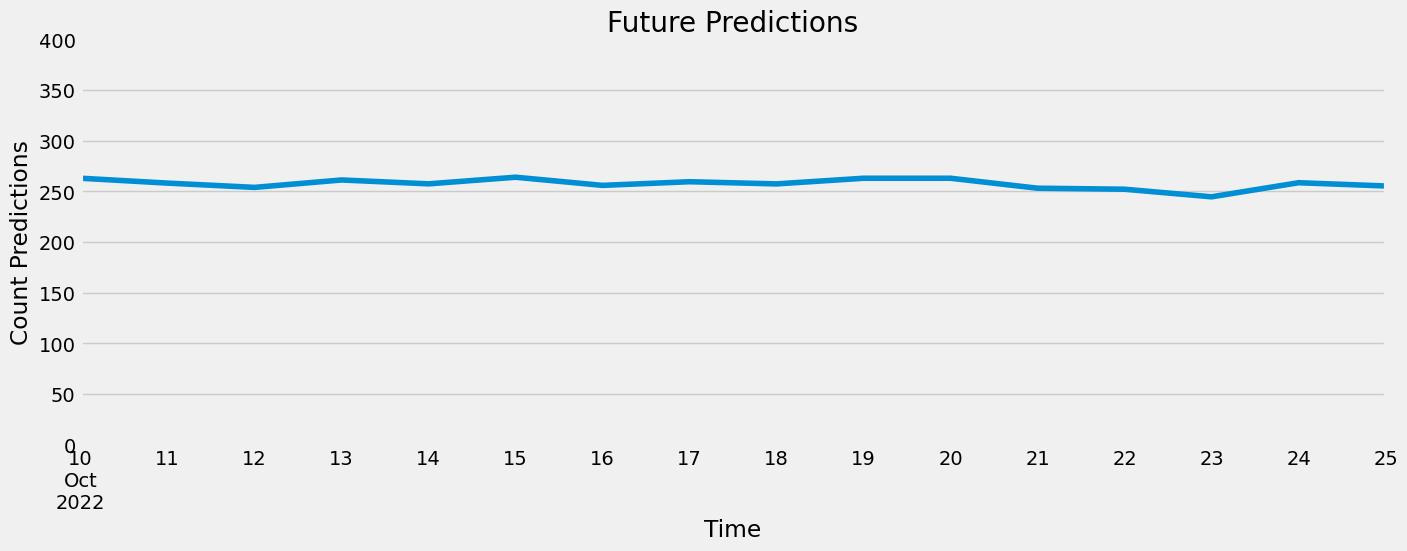

In [9]:
future_with_features['Predictions'].plot()
ax_1=plt.gca()
ax_1.set_title('Future Predictions')
ax_1.set_xlabel('Time')
ax_1.set_ylabel('Count Predictions')
ax_1.set_ylim(0, 400)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()